In [1]:
import os
import sys
import open3d as o3d
import matplotlib.pyplot as plt
import numpy as np

In [2]:
src_path = os.path.abspath('src')
sys.path.append(src_path)

In [3]:
POINTS_PARAMETER = 8192
POINTS_PARAMETER_HAT = 2048

In [4]:
from compute_distances import bhattacharyya_distance, jensen_shannon_divergence, \
    hellinger_distance, wasserstein_distance_O2
    
from helpers import get_point_cloud_from_off   

In [5]:
airplane, airplane_pcd = get_point_cloud_from_off('data/ModelNet40/airplane/test/airplane_0628.off', num_points=POINTS_PARAMETER)
airplane_hat, airplane_hat_pcd = get_point_cloud_from_off('data/ModelNet40/airplane/test/airplane_0628.off', num_points=POINTS_PARAMETER_HAT)
plant, plant_pcd = get_point_cloud_from_off('data/ModelNet40/plant/test/plant_0251.off', num_points=POINTS_PARAMETER)
lamp, lamp_pcd = get_point_cloud_from_off('data/ModelNet40/lamp/test/lamp_0132.off', num_points=POINTS_PARAMETER)

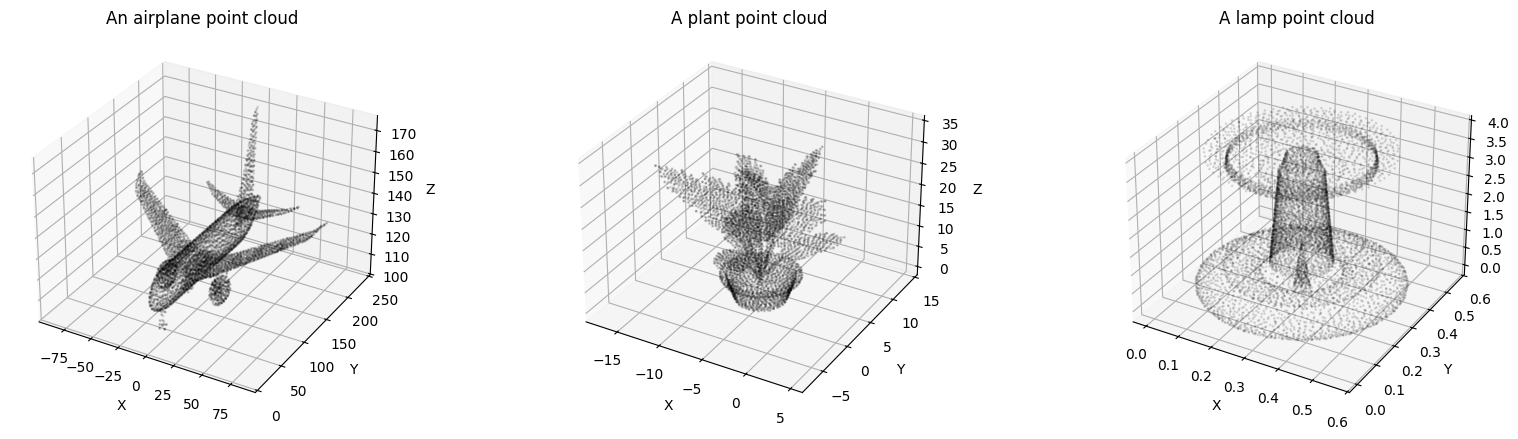

In [6]:
fig = plt.figure(figsize=(20, 5))
ax = fig.add_subplot(131, projection='3d')
ax.scatter(airplane[:, 0], airplane[:, 1], airplane[:, 2], s=1, c='black', alpha=0.1)
#ax.scatter(airplane_hat[:, 0], airplane_hat[:, 1], airplane_hat[:, 2], s=1, c='lime', alpha=0.5)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('An airplane point cloud')
ax = fig.add_subplot(132, projection='3d')
ax.scatter(plant[:, 0], plant[:, 1], plant[:, 2], s=1, c='black', alpha=0.1)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('A plant point cloud');
ax = fig.add_subplot(133, projection='3d')
ax.scatter(lamp[:, 0], lamp[:, 1], lamp[:, 2], s=1, c='black', alpha=0.1)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('A lamp point cloud');

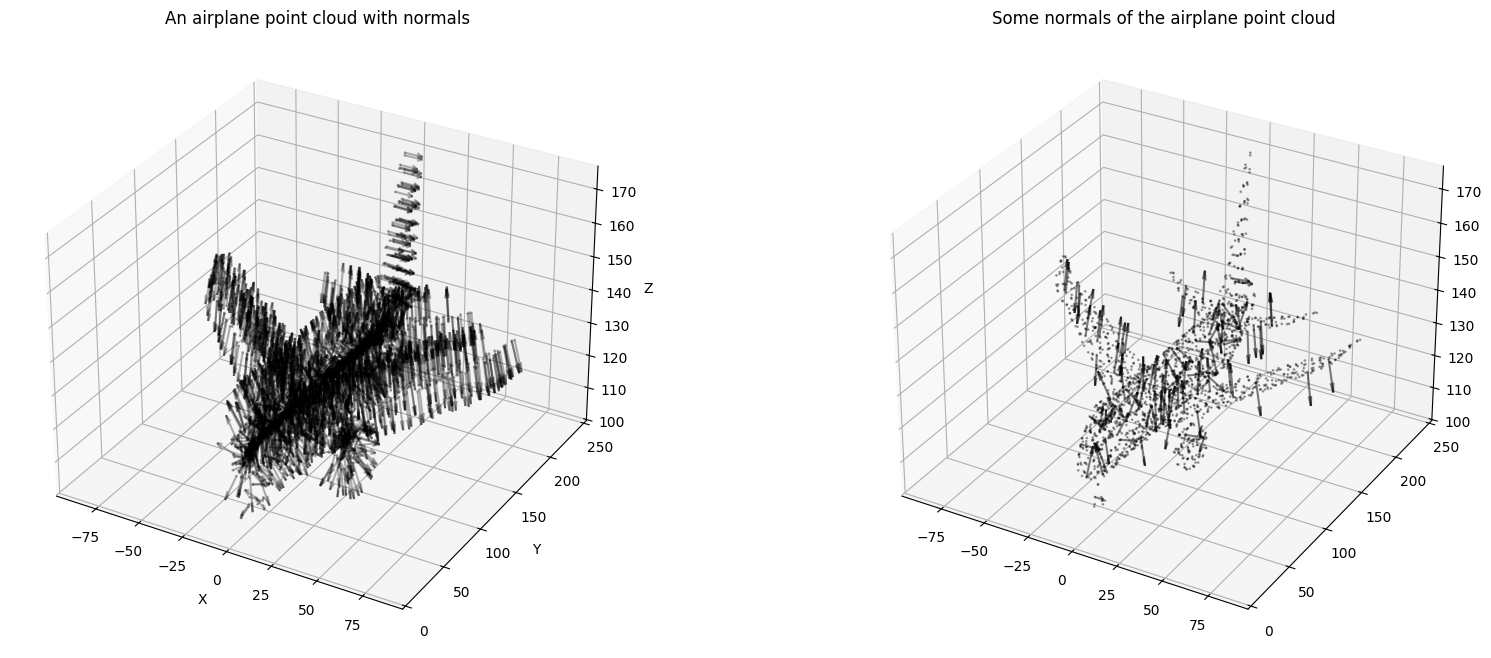

In [7]:
airplane_hat_pcd.estimate_normals(search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=10, max_nn=30))
airplane_hat_pcd.normalize_normals()
airplane_normals = np.asarray(airplane_hat_pcd.normals)

points = airplane_hat
normals = airplane_normals
num_points_to_plot = int(points.shape[0] * 0.05)
random_indices = np.random.choice(points.shape[0], num_points_to_plot, replace=False)

points_plot = points[random_indices, :]
normals_plot = normals[random_indices, :]

fig = plt.figure(figsize=(20, 8))
ax = fig.add_subplot(121, projection='3d')
ax.scatter(airplane_hat[:, 0], airplane_hat[:, 1], airplane_hat[:, 2], s=1, c='gray', alpha=0.5)
scale_factor = 10
ax.quiver(airplane_hat[:, 0], airplane_hat[:, 1], airplane_hat[:, 2], 
              airplane_normals[:, 0] * scale_factor, airplane_normals[:, 1] * scale_factor, airplane_normals[:, 2] * scale_factor,
              color='black', length=1, normalize=False, label='Normals', alpha=0.3)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('An airplane point cloud with normals');

ax = fig.add_subplot(122, projection='3d')

ax.scatter(airplane_hat[:, 0], airplane_hat[:, 1], airplane_hat[:, 2], s=1, c='black', alpha=0.3)
#ax.scatter(points_plot[:, 0], points_plot[:, 1], points_plot[:, 2], s=1, c='blue', alpha=1)

scale_factor = 10 
ax.quiver(points_plot[:, 0], points_plot[:, 1], points_plot[:, 2], 
          normals_plot[:, 0] * scale_factor, normals_plot[:, 1] * scale_factor, normals_plot[:, 2] * scale_factor,
          color='black', length=1, normalize=False, label='Normales', alpha=0.5)

ax.set_title('Some normals of the airplane point cloud');

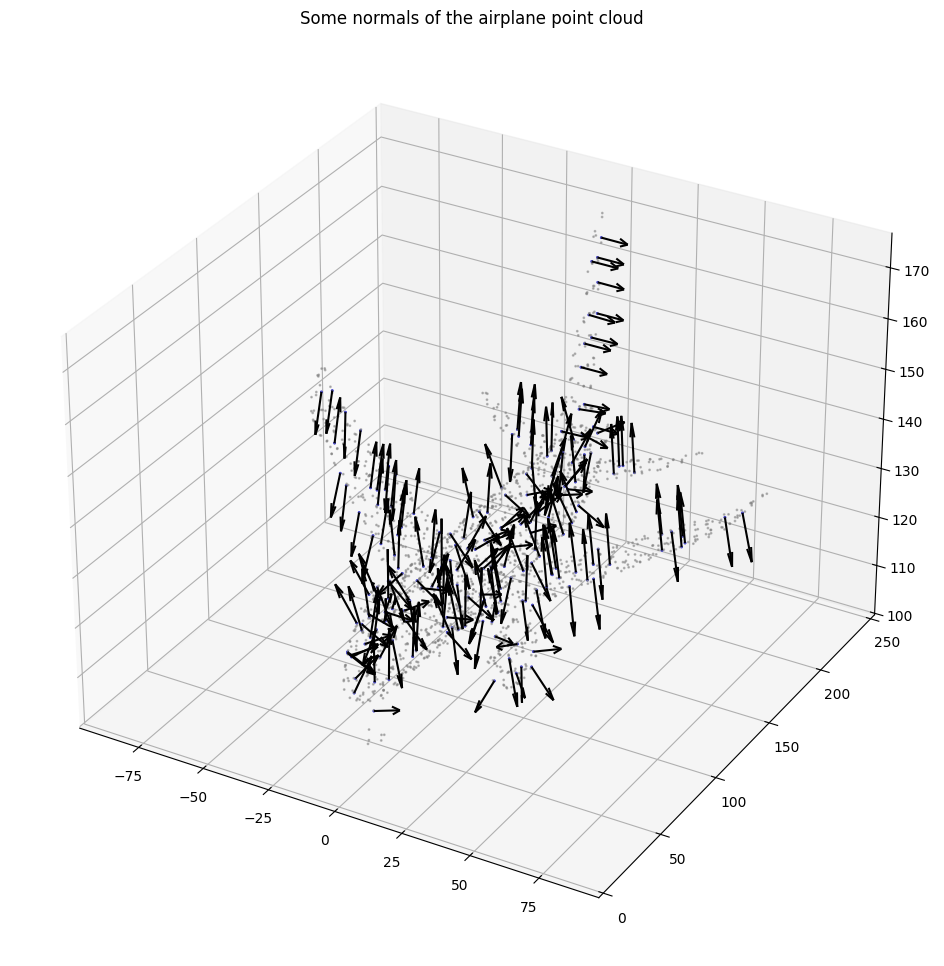

In [8]:
points = airplane_hat
normals = airplane_normals
num_points_to_plot = int(points.shape[0] * 0.1)
random_indices = np.random.choice(points.shape[0], num_points_to_plot, replace=False)

points_plot = points[random_indices, :]
normals_plot = normals[random_indices, :]

fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(airplane_hat[:, 0], airplane_hat[:, 1], airplane_hat[:, 2], s=1, c='gray', alpha=0.5)
ax.scatter(points_plot[:, 0], points_plot[:, 1], points_plot[:, 2], s=1, c='blue', alpha=1)

scale_factor = 10 
ax.quiver(points_plot[:, 0], points_plot[:, 1], points_plot[:, 2], 
          normals_plot[:, 0] * scale_factor, normals_plot[:, 1] * scale_factor, normals_plot[:, 2] * scale_factor,
          color='black', length=1, normalize=False, label='Normales')

ax.set_title('Some normals of the airplane point cloud')
plt.show()

#### DEEP LEARNING PART ####

In [9]:
import tensorflow as tf
from deepl_helpers import get_tf_embedding 

In [10]:
model_dir = 'weights/pointnet_model'

In [11]:
try:
    model = tf.saved_model.load(model_dir)
    inference_func = model.signatures['serving_default'] 
except KeyError:
    print("Warning: 'serving_default' not found. Using the model object directly.")
    inference_func = model

In [12]:
get_tf_embedding(model, airplane_hat)

array([8.6313206e-01, 1.3562801e-01, 4.5242281e-09, 1.2388375e-03,
       1.0947834e-21, 1.0985449e-20, 5.1575608e-07, 7.5591679e-11,
       5.0884682e-07, 1.6924630e-11], dtype=float32)

In [15]:
pc_array = airplane_hat
loaded_model = model
# 1. Convert to TensorFlow tensor and adjust shape
pc_tensor = tf.convert_to_tensor(pc_array, dtype=tf.float32)
pc_tensor = tf.expand_dims(pc_tensor, axis=0) # Add the batch dimension

# 2. Get the embedding
# The output from a SavedModel can be a dictionary
model_output = loaded_model(pc_tensor)


# Try to find the correct key for the embedding
# Example keys could be 'embedding', 'features', 'dense_0', etc.
if isinstance(model_output, dict):
    # You need to print the keys to find the correct one
    embedding_vector = model_output['dense_0'] # Change this key
    print("here")
else:
    # If the output is a single tensor, it might be the embedding itself.
    embedding_vector = model_output

embedding_vector.numpy().flatten()

array([8.6313206e-01, 1.3562801e-01, 4.5242281e-09, 1.2388375e-03,
       1.0947834e-21, 1.0985449e-20, 5.1575608e-07, 7.5591679e-11,
       5.0884682e-07, 1.6924630e-11], dtype=float32)

In [16]:
for key, value in model_output.items():
        print(f"Key: '{key}', Shape: {value.shape}")

AttributeError: 'tensorflow.python.framework.ops.EagerTensor' object has no attribute 'items'

In [17]:
pc_array = airplane_hat
loaded_model = model

# 1. Convert to TensorFlow tensor and adjust shape
pc_tensor = tf.convert_to_tensor(pc_array, dtype=tf.float32)
pc_tensor = tf.expand_dims(pc_tensor, axis=0) # Add the batch dimension

# 2. Get the model's output
model_output = loaded_model(pc_tensor)

# 3. Inspect the output if it's a dictionary
if isinstance(model_output, dict):
    print("Model output is a dictionary. Keys and shapes:")
    for key, value in model_output.items():
        print(f"Key: '{key}', Shape: {value.shape}")
else:
    print("Model output is a single tensor. Shape:")
    print(f"Shape: {model_output.shape}")

Model output is a single tensor. Shape:
Shape: (1, 10)


In [21]:
!pip install torch

  Using cached sympy-1.14.0-py3-none-any.whl.metadata (12 kB)
  Using cached networkx-3.4.2-py3-none-any.whl.metadata (6.3 kB)
  Using cached mpmath-1.3.0-py3-none-any.whl.metadata (8.6 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.6/73.6 MB 11.1 MB/s eta 0:00:0000:0100:01
Using cached sympy-1.14.0-py3-none-any.whl (6.3 MB)
Using cached mpmath-1.3.0-py3-none-any.whl (536 kB)
Using cached networkx-3.4.2-py3-none-any.whl (1.7 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6/6 [torch]32m5/6 [torch]]x]
